# Import Dependencies

In [20]:
import torch
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from transformers import pipeline

# Load/Download Sentiment Analysis Pipeline

In [21]:
classifier = pipeline("sentiment-analysis")
type(classifier)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


transformers.pipelines.text_classification.TextClassificationPipeline

# Perform Some Test Cases

In [22]:
sample_texts = [
        "This is such a great movie!",
        "This show was not interesting",
        "This show was interesting",
        "This show was not bad at all",
        "I can't say that this was a good movie"
        ]

sentiments = classifier(sample_texts)

result_dict = {}
result_dict['TEXT'] = []
result_dict['SENTIMENT'] = []
result_dict['SCORE'] = []

for i in range(len(sentiments)):
        result_dict['TEXT'].append(sample_texts[i])
        result_dict['SENTIMENT'].append(sentiments[i]['label'])
        result_dict['SCORE'].append(sentiments[i]['score'])

result_df = pd.DataFrame(result_dict)
result_df

,TEXT,SENTIMENT,SCORE
0,This is such a great movie!,POSITIVE,0.999876
1,This show was not interesting,NEGATIVE,0.999787
2,This show was interesting,POSITIVE,0.999747
3,This show was not bad at all,POSITIVE,0.998742
4,I can't say that this was a good movie,NEGATIVE,0.927845


# GPU Utilization

In [23]:
torch.cuda.is_available()

False

In [24]:
classifier = pipeline(
                    "sentiment-analysis", 
                    device = 0 if torch.cuda.is_available() else -1
                    )

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [25]:
df_tweets = pd.read_csv('data/AirlineTweets.csv')
df_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [26]:
df_tweets = df_tweets[['text', 'airline_sentiment']]
df_tweets = df_tweets[df_tweets['airline_sentiment'] != 'neutral']
df_tweets['airline_sentiment'] = df_tweets['airline_sentiment'].replace({'negative': 0, 'positive': 1})
df_tweets.head()

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0
5,@VirginAmerica seriously would pay $30 a fligh...,0
6,"@VirginAmerica yes, nearly every time I fly VX...",1


In [27]:
all_texts = df_tweets['text'].tolist()
all_labels = df_tweets['airline_sentiment'].tolist()

In [28]:
all_predictions = classifier(all_texts)
all_predictions

[{'label': 'POSITIVE', 'score': 0.607088029384613},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854251742362976},
 {'label': 'POSITIVE', 'score': 0.9553211331367493},
 {'label': 'POSITIVE', 'score': 0.9827086925506592},
 {'label': 'POSITIVE', 'score': 0.9994851350784302},
 {'label': 'POSITIVE', 'score': 0.9993509650230408},
 {'label': 'POSITIVE', 'score': 0.9940821528434753},
 {'label': 'POSITIVE', 'score': 0.9863133430480957},
 {'label': 'POSITIVE', 'score': 0.9996304512023926},
 {'label': 'NEGATIVE', 'score': 0.9980512857437134},
 {'label': 'POSITIVE', 'score': 0.9964436888694763},
 {'label': 'NEGATIVE', 'score': 0.9968666434288025},
 {'label': 'POSITIVE', 'score': 0.9787647724151611},
 {'label': 'POSITIVE', 'score': 0.9995218515396118},
 {'label': 'NEGATIVE', 'score': 0.9954516291618347},
 {'label': 'POSITIVE', 'score': 0.9995624423027039},
 {'label': 'POSITIVE', 'score': 0.9998748302459

In [32]:
class_dict = {'NEGATIVE': 0, 'POSITIVE': 1}
all_predicted_sentiments = [class_dict[prediction['label']] for prediction in all_predictions]

# Evaluation

In [33]:
accuracy = np.mean(np.array(all_predicted_sentiments) == np.array(all_labels))
print(f'Accuracy: {accuracy}')

Accuracy: 0.8898708950697514


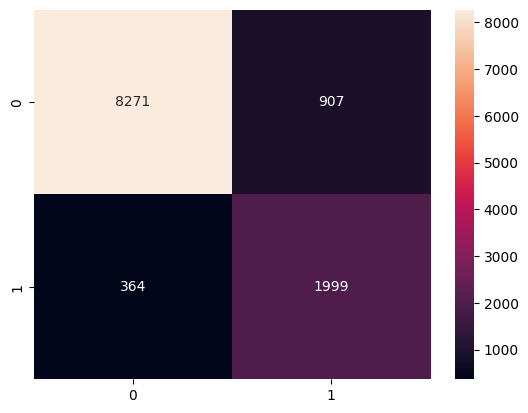

In [36]:
# plot confusion matrix

cm = confusion_matrix(all_labels, all_predicted_sentiments)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [37]:
# F1 score

f1_score(all_labels, all_predicted_sentiments)

0.7587777566900741